# X_wt_tag shape fit

**Motivation:** In the last iteration of the analysis, Patrick used the background estimate derived w/o the $X_{Wt}$ cut, but then looked at 2 bins for the all-had enriched and the QCD enriched variables with a boundary value of 0.75 (i.e, below the $X_{wt}$ = 1.5 cut boundary).

However, there is quite a bit more information in the full $X_{wt}$ distribution, so I'm going to try to make use of it right now to get _more stable_ SFs for these fits.

For completeness, this is the 4b fit table that I made before (it's in my slide deck titled: ggF_PUSH_6_14_21).

<img src="figures/firstFits4b.png">

**What are we looking for?** 
- That we have roughly stable SFs for each physics sample across the years.
- Even more importantly, that we can have mostly consistent results b/w the CR and VR.
- We really care about pinning down the QCD normalization since this will drive our sensitivity.




Cool beans, I had popped most of my code into Sean's `non-resonant-studies` folder alreadfy!!

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap

from scipy.optimize import curve_fit

import os
              
dirname = '../../hh4b/hh4b-plots'
os.sys.path+= [dirname,'../non-resonant-studies/']

from lim_utils import lumi as L 
from utils import systs, calc_bstrap, get_wlab, cat_sel
from utils import enrichedRegions, f, getFit
import pyhf

from hh4b_plots.colors import *
from hh4b_plots.phys_utils import target_to_label
from hh4b_plots.hh4b_plots import hh4b_plots

plt.style.use(os.path.join(dirname, 'hh4b_plots/stylesheets/ATLAS.mplstyle'))

%load_ext autoreload
%autoreload 2

Using uproot4
Using uproot4


**Set up tables**

In [2]:
yrs = [16,17,18]
mcs = ['a','d','e']
bcat='3b1l'

In [3]:
#idx = ['CR 1 SF','VR SF','extrap norm (new)']
idx = ['CR 1 SF','CR 2 SF','extrap norm (new)']
cols = pd.MultiIndex.from_product([yrs,['semi-lep','all-had','QCD']])

sfs = pd.DataFrame(0, index=idx, columns=cols)
sfs

16                   17                   18          \
                  semi-lep all-had QCD semi-lep all-had QCD semi-lep all-had   
CR 1 SF                  0       0   0        0       0   0        0       0   
CR 2 SF                  0       0   0        0       0   0        0       0   
extrap norm (new)        0       0   0        0       0   0        0       0   

                       
                  QCD  
CR 1 SF             0  
CR 2 SF             0  
extrap norm (new)   0

**Load in the data**

In [4]:
# fDir = '../data/RR/cryptotuples/ggF_rw_pre_Xwt/'
# figDir = 'figures/rings/'
# outDir = '../stats-results/ttbar_eigen/'

fDir = '../data/RR/cryptotuples/ttbar/quads/rw_pre_Xwt/'
figDir = 'figures/Q45/'
outDir = '../stats-results/ttbar_quad/'

### Get the enriched regions

**Note:**  Since Michael told me I can stll use the same enriched regions that I was using before (b/c I want to use as much information as I can), I should still be able to use the same `enrichedRegions` function

In [5]:
Xwt_bins = np.append(np.linspace(0,7,15),np.inf)
wl = get_wlab(bcat)

In [6]:
Xwt_bins

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , inf])

In [7]:
for yr, mc in zip(yrs,mcs):

    #dat_name = f'{fDir}/data{yr}_NN_100_bootstraps.root'
    dat_name = f'{fDir}/data{yr}_Xhh_45_NN_100_bootstraps.root'
    ah_name  = f'{fDir}/NanoNTuple_allhad_mc16{mc}_NN_100_bootstraps.root'
    sl_name  = f'{fDir}/NanoNTuple_semilep_mc16{mc}_NN_100_bootstraps.root'

    hist_dict = {}

    for fname,physSample,w,s,pre in zip([dat_name,ah_name,sl_name],['dat','ah','sl'],
                                        [None,'mc_sf','mc_sf'],[1,L[yr],L[yr]],['','mc_','mc_']):

        for tname, region in zip(['control','validation','sig'],['cr','vr','sr']):

            print(fname,tname)
            
            k = f'{physSample}_{region}'

            hist_dict[f'{k}_2b']   = enrichedRegions(fname, tname, bcat=f'rw_to_{bcat}', w_col=w,scale=s,
                                                     Xwt_bins=Xwt_bins)
            hist_dict[f'{k}_{bcat}'] = enrichedRegions(fname, tname, bcat=bcat, w_col=w,scale=s,
                                                       Xwt_bins=Xwt_bins)
            hist_dict[f'{k}_rw_to_{bcat}'] = enrichedRegions(fname, tname, bcat=f'rw_to_{bcat}', 
                                                             w_col=f'{pre}NN_{wl}_weight_bstrap_med_{yr}',
                                                             scale=s,Xwt_bins=Xwt_bins)

            hist_dict[f'{k}_rw_to_{bcat}_vr'] = enrichedRegions(fname, tname, bcat=f'rw_to_{bcat}', 
                                                                w_col=f'{pre}NN_{wl}_weight_VRderiv_bstrap_med_{yr}',
                                                                scale=s,Xwt_bins=Xwt_bins)
            
            if physSample == 'dat':
                hist_dict[f'{k}_rw_to_{bcat}_norm'] = enrichedRegions(fname, 
                                                                      tname, 
                                                                      bcat=f'rw_to_{bcat}', 
                                                                      w_col=f'NN_{wl}_weight_bstrap_med_{yr}',
                                                                      scale=s,
                                                                      Xwt_bins=Xwt_bins,
                                                                      normCorr=True)

                hist_dict[f'{k}_rw_to_{bcat}_vr_norm'] = enrichedRegions(fname, 
                                                                         tname, 
                                                                         bcat=f'rw_to_{bcat}', 
                                                                         w_col=f'NN_{wl}_weight_VRderiv_bstrap_med_{yr}',
                                                                         scale=s,
                                                                         Xwt_bins=Xwt_bins,
                                                                         normCorr=True)

    # Save the output histograms
    h_out = { k: v.tolist() for k,v in hist_dict.items() }
    with open(f'{outDir}/fitCRs_{yr}_{bcat}_{len(Xwt_bins)}_Xwt_bins.json','w') as fi:
        json.dump(h_out,fi)
        

../data/RR/cryptotuples/ttbar/quads/rw_pre_Xwt//data16_Xhh_45_NN_100_bootstraps.root control
../data/RR/cryptotuples/ttbar/quads/rw_pre_Xwt//data16_Xhh_45_NN_100_bootstraps.root validation
../data/RR/cryptotuples/ttbar/quads/rw_pre_Xwt//data16_Xhh_45_NN_100_bootstraps.root sig
../data/RR/cryptotuples/ttbar/quads/rw_pre_Xwt//NanoNTuple_allhad_mc16a_NN_100_bootstraps.root control
../data/RR/cryptotuples/ttbar/quads/rw_pre_Xwt//NanoNTuple_allhad_mc16a_NN_100_bootstraps.root validation
../data/RR/cryptotuples/ttbar/quads/rw_pre_Xwt//NanoNTuple_allhad_mc16a_NN_100_bootstraps.root sig
../data/RR/cryptotuples/ttbar/quads/rw_pre_Xwt//NanoNTuple_semilep_mc16a_NN_100_bootstraps.root control
../data/RR/cryptotuples/ttbar/quads/rw_pre_Xwt//NanoNTuple_semilep_mc16a_NN_100_bootstraps.root validation
../data/RR/cryptotuples/ttbar/quads/rw_pre_Xwt//NanoNTuple_semilep_mc16a_NN_100_bootstraps.root sig
../data/RR/cryptotuples/ttbar/quads/rw_pre_Xwt//data17_Xhh_45_NN_100_bootstraps.root control
../data/RR

### Do the 3-component fits

In [9]:
cov_dict = {}

In [10]:
for yr in yrs:
    
    # Load in the histograms which make the fit pieces
    with open(f'{outDir}/fitCRs_{yr}_{bcat}_{len(Xwt_bins)}_Xwt_bins.json') as fi:
        hist_dict = json.load(fi)
    
        for k in hist_dict.keys():
            hist_dict[k] = np.array(hist_dict[k])
    
    ps = {}
    
    for ri,ti in zip(['cr','vr'],['','_vr']):

        p, cov, alpha_2b = getFit(hist_dict,region=ri,target=bcat,train=ti)

        err = np.sqrt(np.diag(cov))
        
        reg = 'CR 1' if ri =='cr' else 'CR 2' if ri == 'vr' else 'none'
        sfs.loc[f'{reg} SF',yr] = [f'{pi:1.3f} $\pm$ {ei:1.3f}' for pi,ei in zip(p, err)]
        ps[ri] = p
        
        cov_dict[f'{yr}_{ri}'] = cov
        
    sfs.loc[f'extrap norm (new)',yr] = ps['vr'] / ps['cr']

In [11]:
sfs

16                                        \
                            semi-lep            all-had                QCD   
CR 1 SF            1.275 $\pm$ 0.158  0.840 $\pm$ 0.076  1.018 $\pm$ 0.022   
CR 2 SF            1.010 $\pm$ 0.127  0.987 $\pm$ 0.072  1.005 $\pm$ 0.022   
extrap norm (new)            0.79177           1.174856           0.986797   

                                  17                                        \
                            semi-lep            all-had                QCD   
CR 1 SF            1.239 $\pm$ 0.130  0.981 $\pm$ 0.068  1.018 $\pm$ 0.019   
CR 2 SF            1.024 $\pm$ 0.112  0.934 $\pm$ 0.064  1.049 $\pm$ 0.020   
extrap norm (new)           0.826266           0.952028           1.030353   

                                  18                                        
                            semi-lep            all-had                QCD  
CR 1 SF            1.135 $\pm$ 0.092  0.943 $\pm$ 0.054  1.014 $\pm$ 0.014  
CR 2 SF            1.089 $\pm$ 0.089  0.935 $\pm$ 0.051  1.028 $\pm$ 0.014  
extrap norm (new)            0.95917           0.991542           1.013599

### Fill in the table and plot the correlation / covariance matrices

In [12]:
def fitCorrAllYrs(inDir='',figDir='',tag=''):

    l = [r'semi-lep $t\bar{t}$',r'all-had $t\bar{t}$','qcd est']
    cmap = LinearSegmentedColormap.from_list("", ['hh:medturquoise','hh:offwhite','hh:darkpink'])

    fig, axes = plt.subplots(2,3,figsize=(18, 12), 
                         gridspec_kw={"height_ratios": [.5,.5],
                                      "width_ratios": [1/3,1/3,1/3],
                                      "wspace" : 0.4, 
                                     }
                        )
    
    for yr,ax_col in zip([16,17,18],axes.T):
    
        # Load in the histograms which make the fit pieces
        with open(f'{inDir}/fitCRs_{yr}_{bcat}_{len(Xwt_bins)}_Xwt_bins.json') as fi:
            hist_dict = json.load(fi)

            for k in hist_dict.keys():
                hist_dict[k] = np.array(hist_dict[k])
    
        for ri, ti,ax in zip(['cr','vr'],['','_vr'],ax_col):
            # Get the fits
            p_i, cov, alpha_2b_i = getFit(hist_dict,region=ri,target=bcat,train=ti)

            # Translate from covariance to correlation
            std = np.sqrt(np.diag(cov))
            den = np.array([[std[i] * std[j] for i in range(len(l))] for j in range(len(l))])
            
            corr = cov / den
            
            v_abs = np.max(np.abs(corr))
            im = ax.imshow(corr,cmap=cmap,vmin=-v_abs,vmax=v_abs)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax,ticks=[-1,0,1])

            ax.set_xticks(range(len(l)))
            ax.set_yticks(range(len(l)))
            ax.set_xticklabels(l,rotation=90*(1-1.2/len(l)))
            ax.set_yticklabels(l)

            # Step 3: Overlay the #s
            for i in range(len(l)):
                for j in range(len(l)):
                    cij = corr[i,j]

                    ax.text(i,j,f'{cij:.2f}',ha='center',va='center')

            ax.set_title(f'20{yr} {target_to_label[bcat]} {ri.upper()}',loc='left')
            ax.tick_params(which='minor', length=0)
            
    # Step 4: Save
    if figDir:
        print(f'{figDir}/fitCorr-{bcat}-CR-VR-16-17-18{tag}.pdf')
        plt.savefig(f'{figDir}/fitCorr-{bcat}-CR-VR-16-17-18{tag}.pdf', bbox_inches='tight')


In [13]:
outDir

'../stats-results/ttbar_quad/'

figures/Q45//fitCorr-3b1l-CR-VR-16-17-18_3compFits.pdf


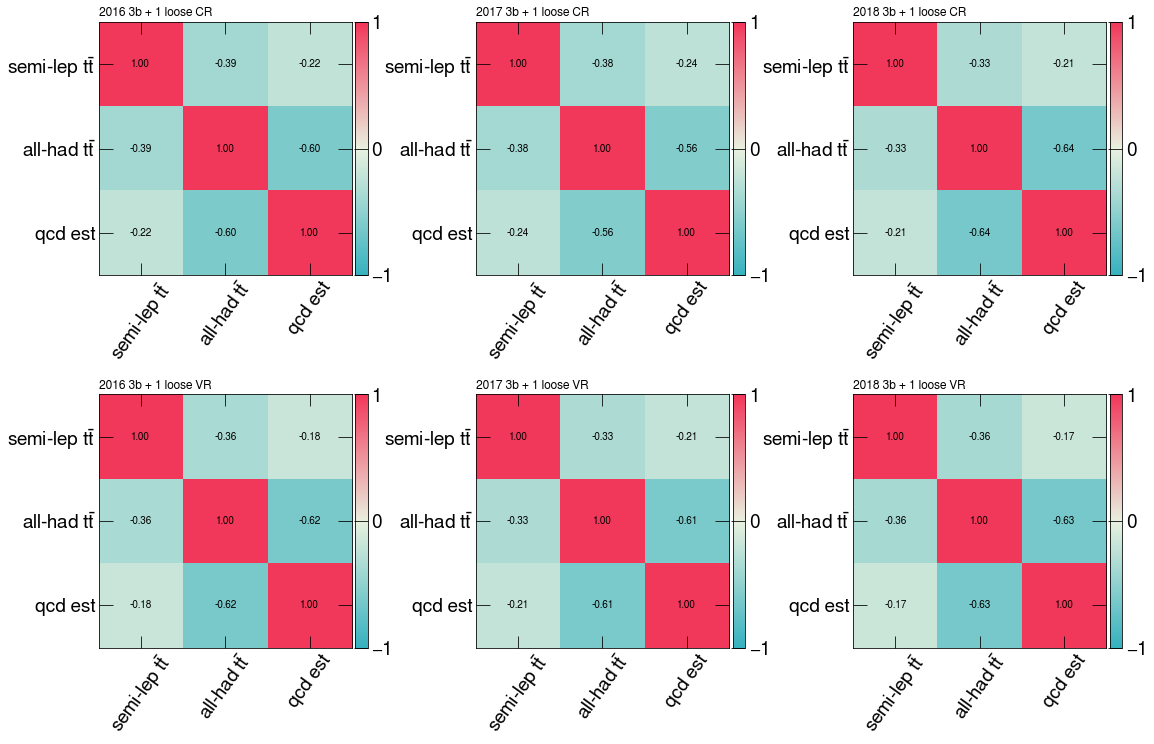

In [14]:
tag ='_3compFits' 
fitCorrAllYrs(outDir,figDir=figDir,tag=tag)

In [15]:
def fitsAllYrs(inDir,region='cr',target='3b1f',train='',Xwt_bins=Xwt_bins,
               rlim1=(.9,1.1),rlim2=(.9,1.1),show_rw=False,figDir='',tag=''):
    '''
    Compare the pre and post-fit ttbar yields plots for all of the years
    '''
    
    lw=2.5
    labels = [r'semi-lep $t\bar{t}$',r'all-had $t\bar{t}$','qcd']
    colors = ['hh:lightturquoise','hh:darkgreen','hh:darkyellow']
    
    fig, axes = plt.subplots(4,3,figsize=(18, 12), #sharex=True,
                             gridspec_kw={"height_ratios": [1/3,1/6,1/3,1/6],
                                          "width_ratios": [1/3,1/3,1/3],
                                          "wspace" : 0.25, "hspace":0.25,
                                          "left":0.1, "bottom":.25}
                            )
    
    for yr,ax_col in zip([16,17,18],axes.T):
    
        # Load in the histograms which make the fit pieces
        with open(f'{inDir}/fitCRs_{yr}_{bcat}_{len(Xwt_bins)}_Xwt_bins.json') as fi:
            hist_dict = json.load(fi)

            for k in hist_dict.keys():
                hist_dict[k] = np.array(hist_dict[k])
    
        # Get the fits
        p_i, cov_i, alpha_2b_i = getFit(hist_dict,region,target,train) 
        u,V = np.linalg.eig(cov_i)
        
        keys = [f'sl_{region}_{target}',f'ah_{region}_{target}',f'qcd_{region}_rw_to_{target}{train}']
        hists = [hist_dict[k] for k in keys]

        hist_comp = np.vstack(hists)
        err = np.sqrt(np.sum((np.sqrt(u.reshape(-1,1)) * np.matmul(V.T,hist_comp))**2,axis=0))
        
        for p,opt,rlim,ax1,ax2 in zip([np.ones(3),p_i],['pre','post'],[rlim1,rlim2],
                                      [ax_col[0],ax_col[2]],[ax_col[1],ax_col[3]]):
            
            prev = 0
            
            Xwt_edg = np.concatenate([[-2], Xwt_bins[:-1],[8]])
            Xwt_mid = 0.5 * (Xwt_edg[1:] + Xwt_edg[:-1])
            widths  = 0.5 * (Xwt_edg[1:] - Xwt_edg[:-1])
                        
            for h,pi,c,l in zip(hists,p,colors,labels):

                ax1.hist(Xwt_mid, Xwt_edg, weights=pi*h,bottom=prev,color=c,label=l)
                prev+=pi*h

            y = hist_dict[f'dat_{region}_{target}']
            ax1.errorbar(Xwt_mid,y,np.sqrt(y),widths,lw=0,elinewidth=lw,
                           color='k',marker='o',label=target)

            # And the ratio panel
            pred = np.vstack(p.reshape(-1,1)*hists).sum(axis=0)

            ax2.errorbar(Xwt_mid,y/pred, np.sqrt(y)/pred,widths,
                         lw=0,elinewidth=lw,color='k',marker='o')

            if show_rw:
                rw = hist_dict[f'dat_{region}_rw_to_{target}_norm']
                
                kwargs = {'color':'hh:darkpink','lw':lw,'histtype':'step'}
                
                ax1.hist(Xwt_mid,Xwt_edg,weights=rw,label='incl rw',**kwargs)
                ax2.hist(Xwt_mid,Xwt_edg,weights=y/rw,**kwargs)
                
            if opt=='post':
                # Hatched line for the error on the prediction
                ax2.fill_between(Xwt_edg,np.append(0,1-err/pred), np.append(0,1+err/pred),step="pre", 
                                   facecolor='None',edgecolor='dimgrey', hatch='\\\\\\\\',lw=0)            

            reg = 'CR 1' if region =='cr' else 'CR 2' if region == 'vr' else region.upper()
            ax1.text(.95,.9,f'20{yr} {reg}\n{opt}-fit',transform=ax1.transAxes,
                     ha='right',va='top',fontsize=17)

            ax1.set_ylabel('Entries',ha='right',y=1,fontsize=15)
            ax2.set_ylabel(f'{target} / pred',fontsize=15)

            ax1.legend(fontsize=11,loc='upper left')
            
            # Draw the Xwt cut that we'll apply
            ymax = ax1.get_ylim()[1]
            ax1.plot([1.5]*2,[0,1.3*ymax],color='hh:darkblue',ls='--',lw=lw)
            ax1.set_ylim(0,1.3*ymax)
                
            for ax in [ax1,ax2]:
                
                ax.set_xticks(range(-1,8))
                ax.set_xlim(-2,8)
                ax.set_xticklabels(['iso $\mu$']+[f'{i}' for i in range(8)])
                
                ax.xaxis.set_ticks(np.linspace(0,8,32),minor=True)
                ax.yaxis.set_minor_locator(AutoMinorLocator())
                
            ax2.plot(Xwt_edg,np.ones_like(Xwt_edg),'k',ls='dotted',lw=lw)
            ax2.set_ylim(rlim)
            ax2.set_xlabel('$X_{Wt}$',ha='right',x=1,labelpad=-15)
    
    if figDir:
        rw_tag = '_rw' if show_rw else ''
        plt.savefig(f'{figDir}/prePostFit-{reg.replace(" ","")}-16-17-18_{bcat}_{len(Xwt_bins)}_Xwt_bins{tag}{rw_tag}.pdf', bbox_inches='tight')


In [16]:
rlim1= (.75,1.25) if bcat=='3b1f' else (0.25,1.75)
rlim2=(.9,1.1)

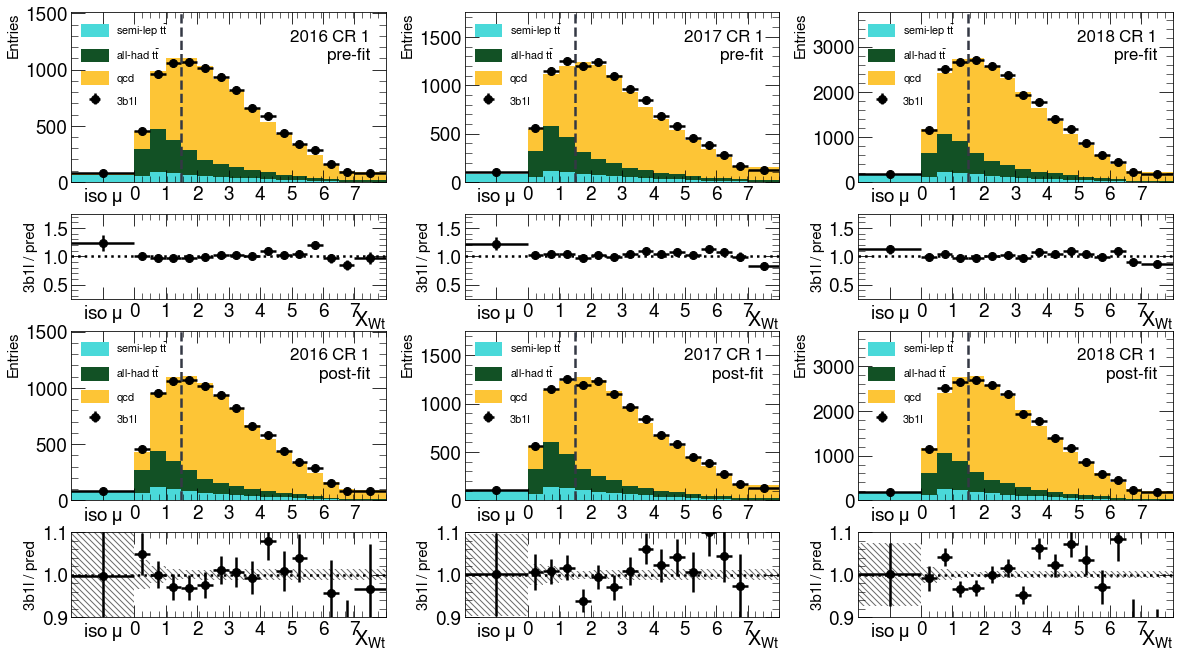

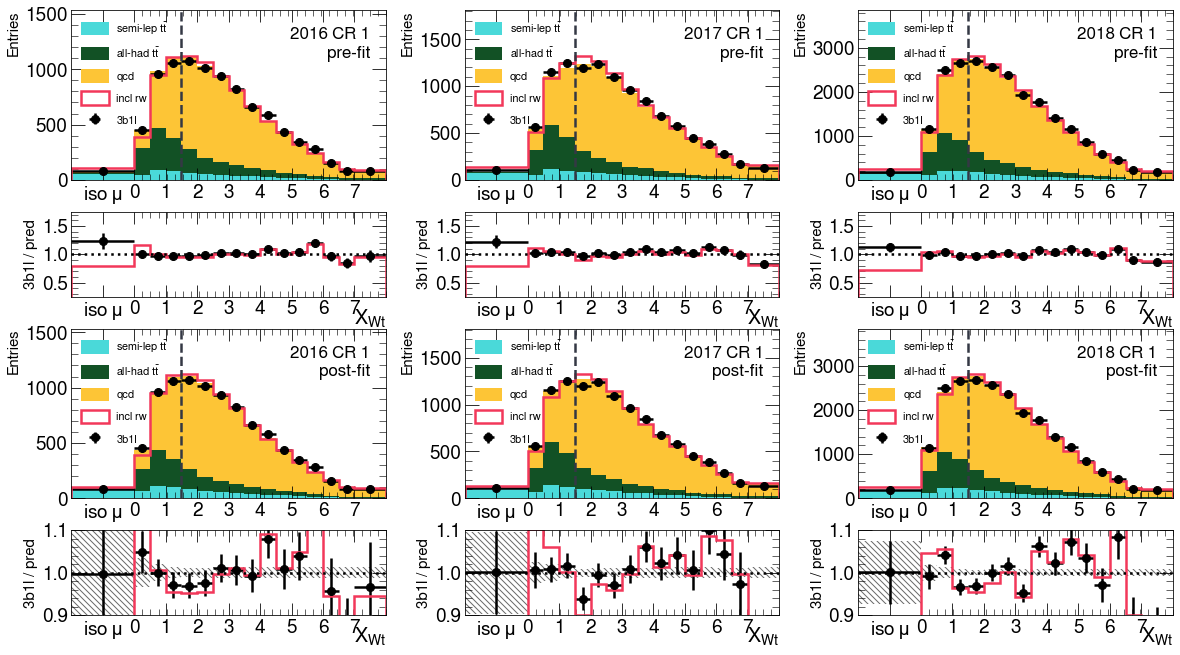

In [17]:
for show_rw in [False,True]:
    fitsAllYrs(outDir,target=bcat,rlim1=rlim1,rlim2=rlim2,figDir=figDir,
               tag=tag,show_rw=show_rw)

**Look at the CR fit in the VR**

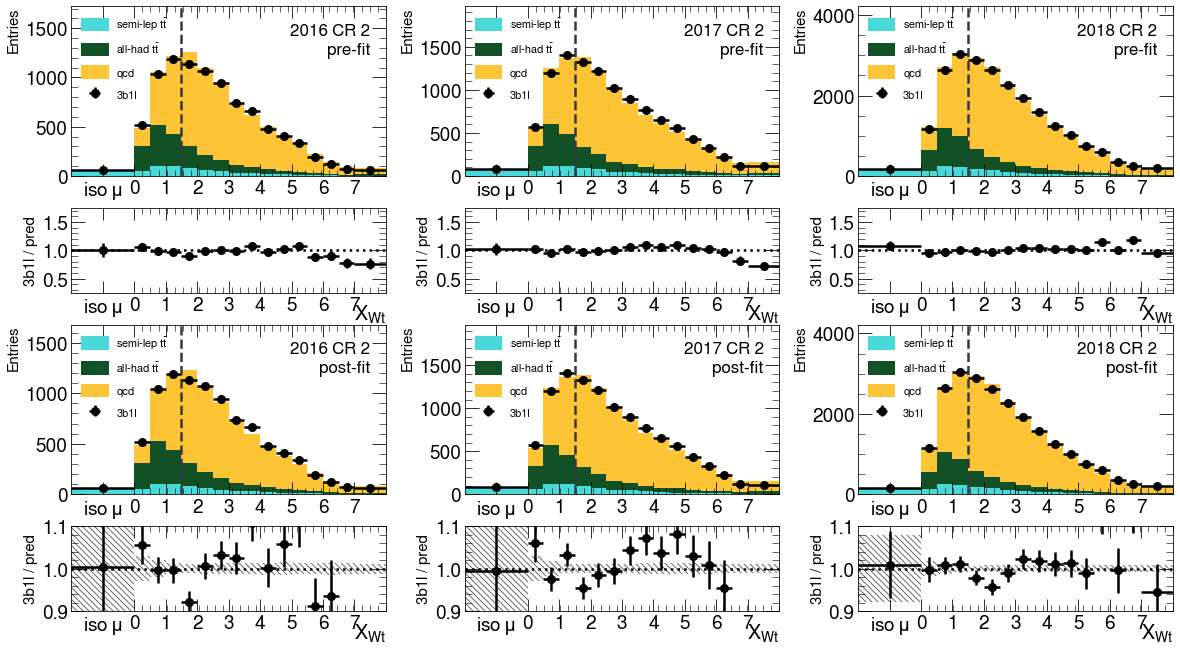

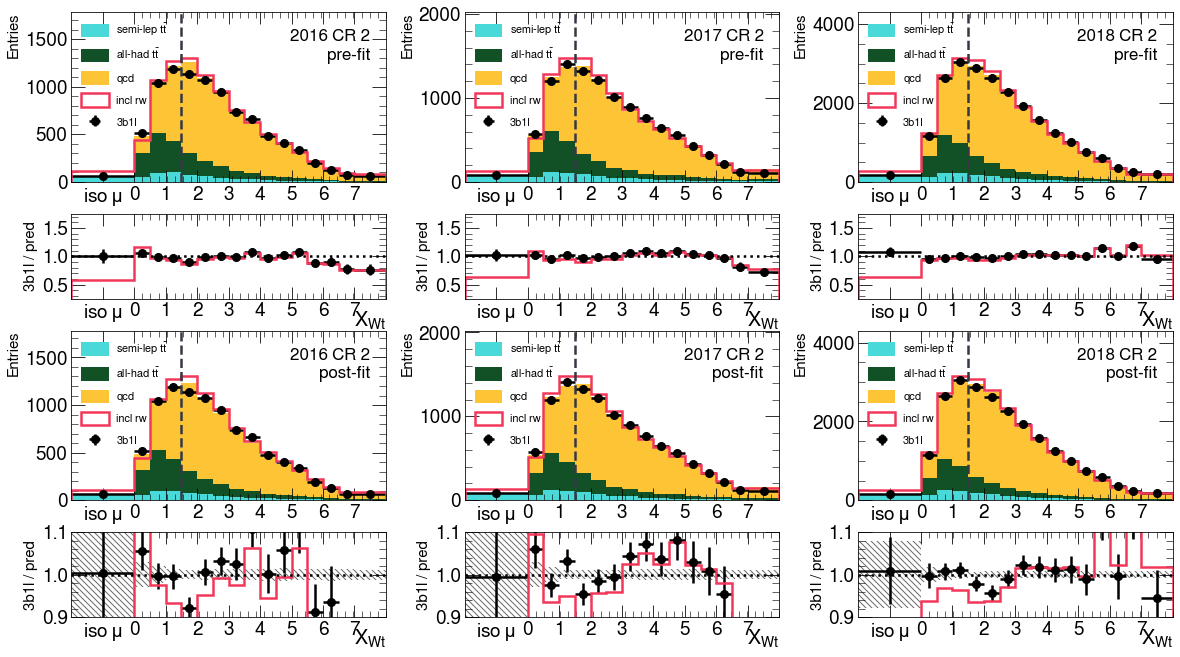

In [18]:
for show_rw in [False,True]:
    fitsAllYrs(outDir,'vr',target=bcat,#train='_vr',
               rlim1=rlim1,rlim2=rlim2,figDir=figDir,
               tag=tag,show_rw=show_rw)

/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/scipy/optimize/minpack.py:755: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


LinAlgError: Array must not contain infs or NaNs

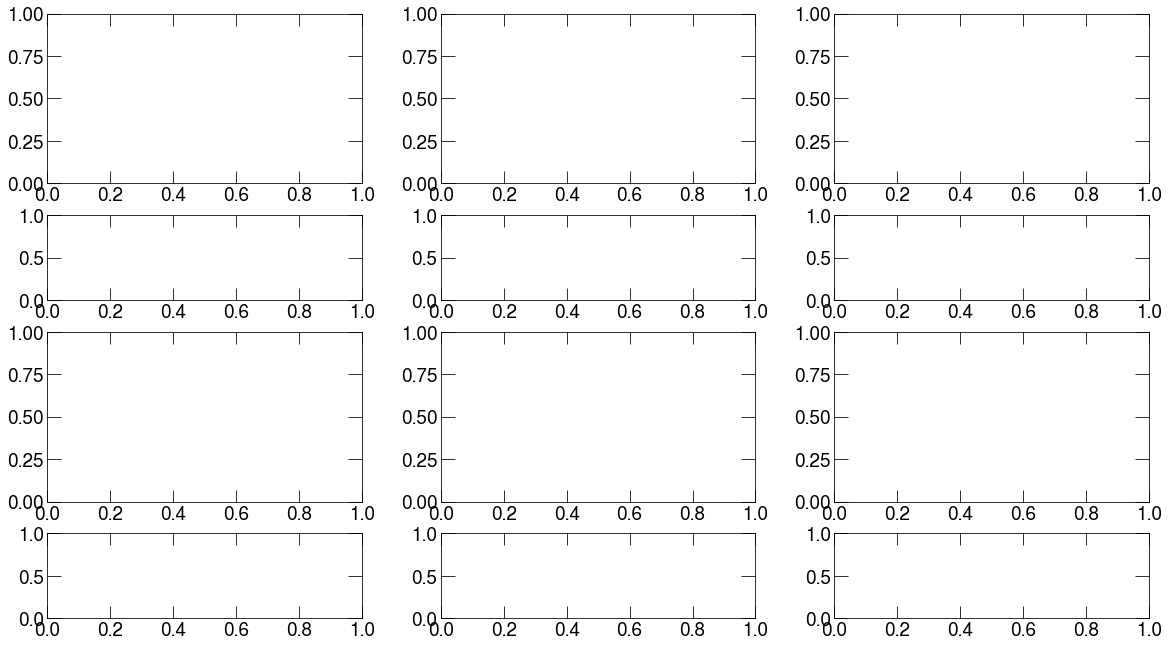

In [19]:
fitsAllYrs(outDir,'sr',target=bcat,#train='_vr',
           rlim1=rlim1,rlim2=rlim2,figDir=figDir,
           tag=tag,show_rw=show_rw)

**VR fits in CR and VR**

In [ ]:
show_rw = True

for ri in ['cr', 'vr','sr']:
    fitsAllYrs(outDir,ri,target=bcat,train='_vr',
               rlim1=rlim1,rlim2=rlim2,figDir=figDir,
               tag=tag+'_VRw',show_rw=show_rw)

In [ ]:
len(Xwt_bins)